In [27]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [16]:
BATCH_SIZE = 32
IMAGE_SIZE = 256

In [17]:
# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [18]:
# Preprocess the dataset
class_names = dataset.class_names
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [12]:
# Load and preprocess the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [19]:
# Data augmentation and normalization
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y)).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y)).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
# Load MobileNetV3 model
base_model = tf.keras.applications.MobileNetV3Small(weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False)

In [21]:
# Freeze base model
base_model.trainable = False

In [22]:
# Add classification head
inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Optional dropout layer
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

In [23]:
# Compile the model
model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)

Epoch 1/50


54/54 [==============================] - 16s 255ms/step - loss: 0.6155 - accuracy: 0.7286 - val_loss: 1.2345 - val_accuracy: 0.4526
Epoch 2/50
54/54 [==============================] - 13s 244ms/step - loss: 0.2837 - accuracy: 0.9132 - val_loss: 1.3491 - val_accuracy: 0.4784
Epoch 3/50
54/54 [==============================] - 14s 255ms/step - loss: 0.1984 - accuracy: 0.9421 - val_loss: 1.4808 - val_accuracy: 0.4741
Epoch 4/50
54/54 [==============================] - 13s 244ms/step - loss: 0.1426 - accuracy: 0.9653 - val_loss: 1.5544 - val_accuracy: 0.4914
Epoch 5/50
54/54 [==============================] - 14s 250ms/step - loss: 0.1219 - accuracy: 0.9676 - val_loss: 1.7203 - val_accuracy: 0.4741
Epoch 6/50
54/54 [==============================] - 14s 253ms/step - loss: 0.1077 - accuracy: 0.9682 - val_loss: 1.7382 - val_accuracy: 0.5043
Epoch 7/50
54/54 [==============================] - 14s 254ms/step - loss: 0.0988 - accuracy: 0.9728 - val_loss: 1.7804 - val_accuracy: 0.50

In [25]:
# Evaluate the model
scores = model.evaluate(test_ds)
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

8/8 [==============================] - 1s 103ms/step - loss: 4.0438 - accuracy: 0.4844
Test Loss: 4.0437703132629395
Test Accuracy: 0.484375


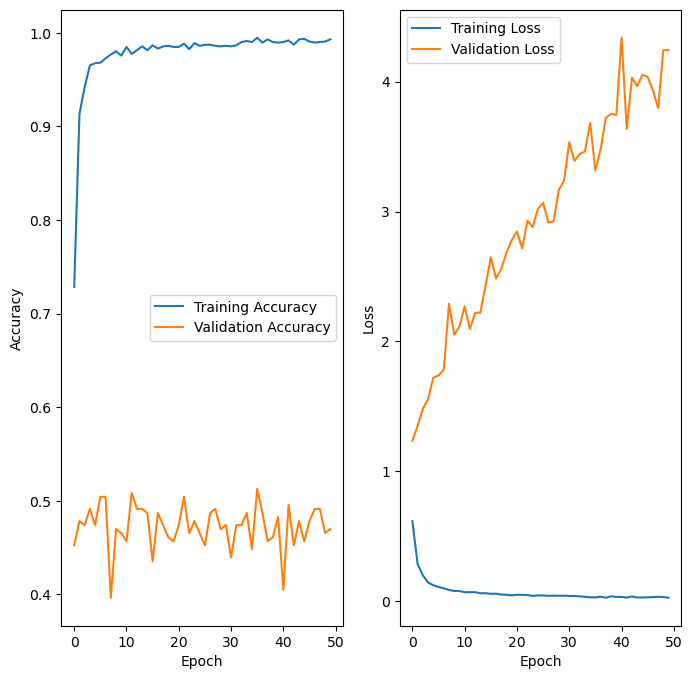

In [26]:
# Plot training history
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 107ms/step


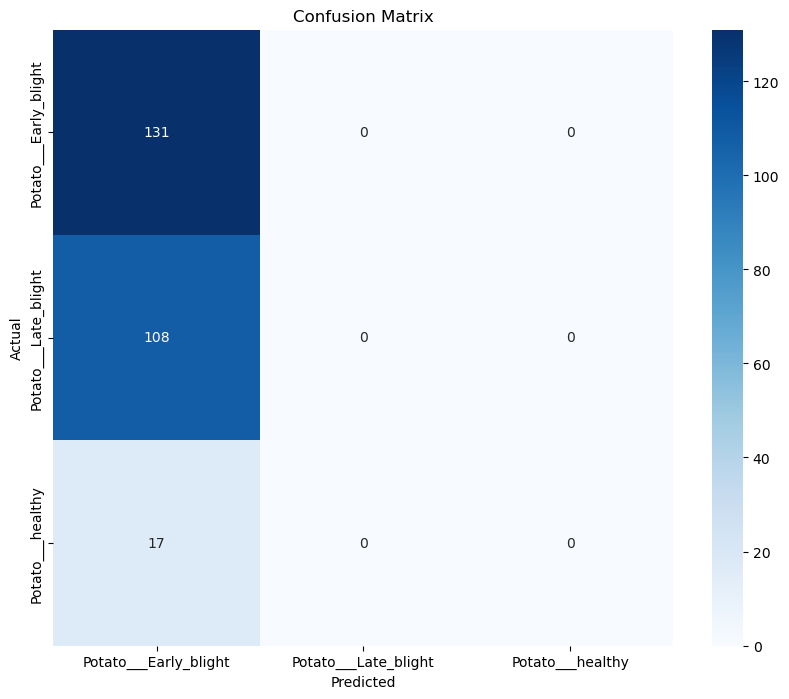

In [28]:
# Confusion Matrix
y_pred = []
y_true = []
for images, labels in test_ds:
    y_pred_batch = model.predict(images)
    y_pred.extend(np.argmax(y_pred_batch, axis=1))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()